### Baseline Models

In [1]:
# necessary modules
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing Pipeline

In [2]:
def preprocess_data(df, test_size=0.2, random_state=42):
    # Define target variables and feature variables
    X = df.drop(columns=['DEP_DATE_TIME', 'ACC_DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DELAY_GROUP', 'WEATHER_DELAY', 'CANCELLED', 'NAS_DELAY'])
    y = df['DEP_DELAY_GROUP'].replace({-2: 0, -1: 0})  # Replace -2 and -1 with 0
    
    # Define numerical and categorical columns
    categorical_cols = ['ORIGIN', 'DEST']
    numerical_cols = [col for col in X.columns if col not in categorical_cols]
    
    # Register feature names for SHAP
    feature_names = X.columns

    # Train-test split (not random, but sequential)
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Ensure encoder learns all categories, even those missing in training
    all_categories = {col: X[col].unique() for col in categorical_cols}
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(categories=[all_categories[col] for col in categorical_cols], drop='first', handle_unknown='ignore'), categorical_cols)
        ])
    
    # Preprocess the data (Fit on training data and transform both training and test data)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_torch = torch.FloatTensor(X_train_processed.toarray())
    Y_train_torch = torch.LongTensor(Y_train.values)
    X_test_torch = torch.FloatTensor(X_test_processed.toarray())
    Y_test_torch = torch.LongTensor(Y_test.values)

    # Normalize data
    scaler = StandardScaler()
    X_train_torch = torch.tensor(scaler.fit_transform(X_train_torch), dtype=torch.float32)
    X_test_torch = torch.tensor(scaler.transform(X_test_torch), dtype=torch.float32)
    
    # Generate feature names after OneHotEncoding for categorical columns
    categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = numerical_cols + list(categorical_feature_names)
    
    return X_train_torch, X_test_torch, Y_train_torch, Y_test_torch, feature_names

### Multinomial Logistic Regression Function

In [4]:
def train_multinomial_logistic_regression(X_train, Y_train, X_test, Y_test, num_epochs=100, lr=0.01):
    class MultinomialLogisticRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(MultinomialLogisticRegression, self).__init__()
            self.linear = nn.Linear(input_dim, output_dim)
        
        def forward(self, x):
            return self.linear(x)  # Softmax is included in CrossEntropyLoss

    # Model, loss, optimizer
    input_dim = X_train.shape[1]  # Number of features after preprocessing
    output_dim = len(torch.unique(Y_train))
    model = MultinomialLogisticRegression(input_dim, output_dim)

    criterion = nn.CrossEntropyLoss()  # Includes softmax
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Lists to store loss and accuracy for plotting
    train_loss_list = []
    train_accuracy_list = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy for this epoch
        with torch.no_grad():
            y_pred = torch.argmax(outputs, dim=1)
            correct = (y_pred == Y_train).float()
            accuracy = correct.mean()

        # Store loss and accuracy
        train_loss_list.append(loss.item())
        train_accuracy_list.append(accuracy.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

    # Evaluate metrics after training
    model.eval()  # Set model to evaluation mode

    # Get predictions for both training and test sets
    with torch.no_grad():
        y_pred_train = torch.argmax(model(X_train), dim=1)
        y_pred_test = torch.argmax(model(X_test), dim=1)

    # Convert predictions and labels to numpy arrays for metric calculations
    y_train_np = Y_train.cpu().numpy()
    y_test_np = Y_test.cpu().numpy()
    y_pred_train_np = y_pred_train.cpu().numpy()
    y_pred_test_np = y_pred_test.cpu().numpy()

    # Calculate accuracy, precision, recall, f1-score for training and test sets
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train_np, y_pred_train_np),
            'precision': precision_score(y_train_np, y_pred_train_np, average='weighted'),
            'recall': recall_score(y_train_np, y_pred_train_np, average='weighted'),
            'f1': f1_score(y_train_np, y_pred_train_np, average='weighted')
        },
        'test': {
            'accuracy': accuracy_score(y_test_np, y_pred_test_np),
            'precision': precision_score(y_test_np, y_pred_test_np, average='weighted'),
            'recall': recall_score(y_test_np, y_pred_test_np, average='weighted'),
            'f1': f1_score(y_test_np, y_pred_test_np, average='weighted')
        }
    }

    print(f"\nTraining Set Metrics:")
    for key, value in metrics['train'].items():
        print(f"{key.capitalize()}: {value:.4f}")
    
    print(f"\nTest Set Metrics:")
    for key, value in metrics['test'].items():
        print(f"{key.capitalize()}: {value:.4f}")

    # Plot Loss
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(4, 4))
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Across Epochs')
    plt.legend()
    plt.savefig('training_loss_plot_MLR.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(4, 4))
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Across Epochs')
    plt.legend()
    plt.savefig('training_accuracy_plot_MLR.png', dpi=300, bbox_inches='tight')
    plt.show()

    return model, metrics

### Decision Tree Model

In [5]:
class SimpleDecisionTree:
    def __init__(self, max_depth=10, min_samples_leaf=50):
        self.model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,  # Minimum samples per leaf
            min_samples_split=50,               # Minimum samples required to split
            max_leaf_nodes=12                   # Limit total number of leaf nodes
        )

    def fit(self, X_train, Y_train):
        self.model.fit(X_train, Y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def get_feature_importances(self):
        return self.model.feature_importances_

def train_decision_tree(X_train_torch, X_test_torch, Y_train_torch, Y_test_torch, feature_names):
    # Convert PyTorch tensors to Pandas DataFrame using the feature names
    X_train_df = pd.DataFrame(X_train_torch.numpy(), columns=feature_names)
    X_test_df = pd.DataFrame(X_test_torch.numpy(), columns=feature_names)

    # Convert labels to numpy arrays
    Y_train = Y_train_torch.numpy()
    Y_test = Y_test_torch.numpy()

    # Initialize and train model
    model = SimpleDecisionTree()
    model.fit(X_train_df, Y_train)

    # Create figure for decision tree visualization
    plt.figure(figsize=(20, 10))
    plot_tree(
        model.model,
        filled=True,
        feature_names=feature_names,
        class_names=np.unique(Y_train).astype(str),
        fontsize=14,
        max_depth=2, 
        proportion=True,
        precision=1,
        rounded=True,
        impurity=False,
        node_ids=False,
        label='root',
    )
    plt.title("Decision Tree Visualization (Simplified)", pad=30, fontsize=16)
    plt.savefig('decision_tree_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(12, 6))
    importance_data = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.get_feature_importances()
    })
    importance_data = importance_data[importance_data['Importance'] > 0].sort_values('Importance', ascending=True)
    plt.barh(importance_data['Feature'], importance_data['Importance'], color='skyblue', edgecolor='navy')
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('Feature Importance in Decision Tree', fontsize=14, pad=20)
    plt.savefig('feature_importance_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Predict on the training and test sets
    y_pred_train = model.predict(X_train_df)
    y_pred_test = model.predict(X_test_df)

    # Calculate metrics
    metrics = {
        'train': {
            'accuracy': accuracy_score(Y_train, y_pred_train),
            'precision': precision_score(Y_train, y_pred_train, average='weighted'),
            'recall': recall_score(Y_train, y_pred_train, average='weighted'),
            'f1': f1_score(Y_train, y_pred_train, average='weighted')
        },
        'test': {
            'accuracy': accuracy_score(Y_test, y_pred_test),
            'precision': precision_score(Y_test, y_pred_test, average='weighted'),
            'recall': recall_score(Y_test, y_pred_test, average='weighted'),
            'f1': f1_score(Y_test, y_pred_test, average='weighted')
        }
    }

    print("\nTraining Set Metrics:")
    for key, value in metrics['train'].items():
        print(f"{key.capitalize()}: {value:.4f}")
    
    print("\nTest Set Metrics:")
    for key, value in metrics['test'].items():
        print(f"{key.capitalize()}: {value:.4f}")

    return model, metrics

### JFK Baseline Models

In [8]:
# import dataset
merged_jfk_df = pd.read_csv('data/complete/JFK_final_df.csv')

# preprocessing
X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk = preprocess_data(merged_jfk_df)

Epoch [10/100], Loss: 2.5948, Accuracy: 0.1522
Epoch [20/100], Loss: 2.5239, Accuracy: 0.2113
Epoch [30/100], Loss: 2.4543, Accuracy: 0.2783
Epoch [40/100], Loss: 2.3862, Accuracy: 0.3454
Epoch [50/100], Loss: 2.3196, Accuracy: 0.4061
Epoch [60/100], Loss: 2.2545, Accuracy: 0.4587
Epoch [70/100], Loss: 2.1910, Accuracy: 0.5035
Epoch [80/100], Loss: 2.1290, Accuracy: 0.5432
Epoch [90/100], Loss: 2.0688, Accuracy: 0.5785
Epoch [100/100], Loss: 2.0102, Accuracy: 0.6107

Training Set Metrics:
Accuracy: 0.6138
Precision: 0.7634
Recall: 0.6138
F1: 0.6789

Test Set Metrics:
Accuracy: 0.6005
Precision: 0.7426
Recall: 0.6005
F1: 0.6624


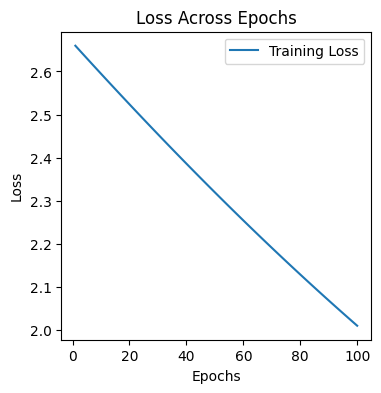

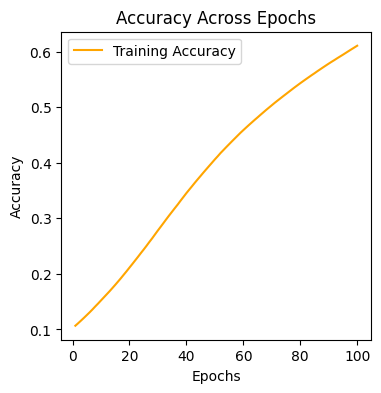

In [9]:
jfk_MLR_model, jfk_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_jfk, Y_train_torch_jfk, X_test_torch_jfk, Y_test_torch_jfk)


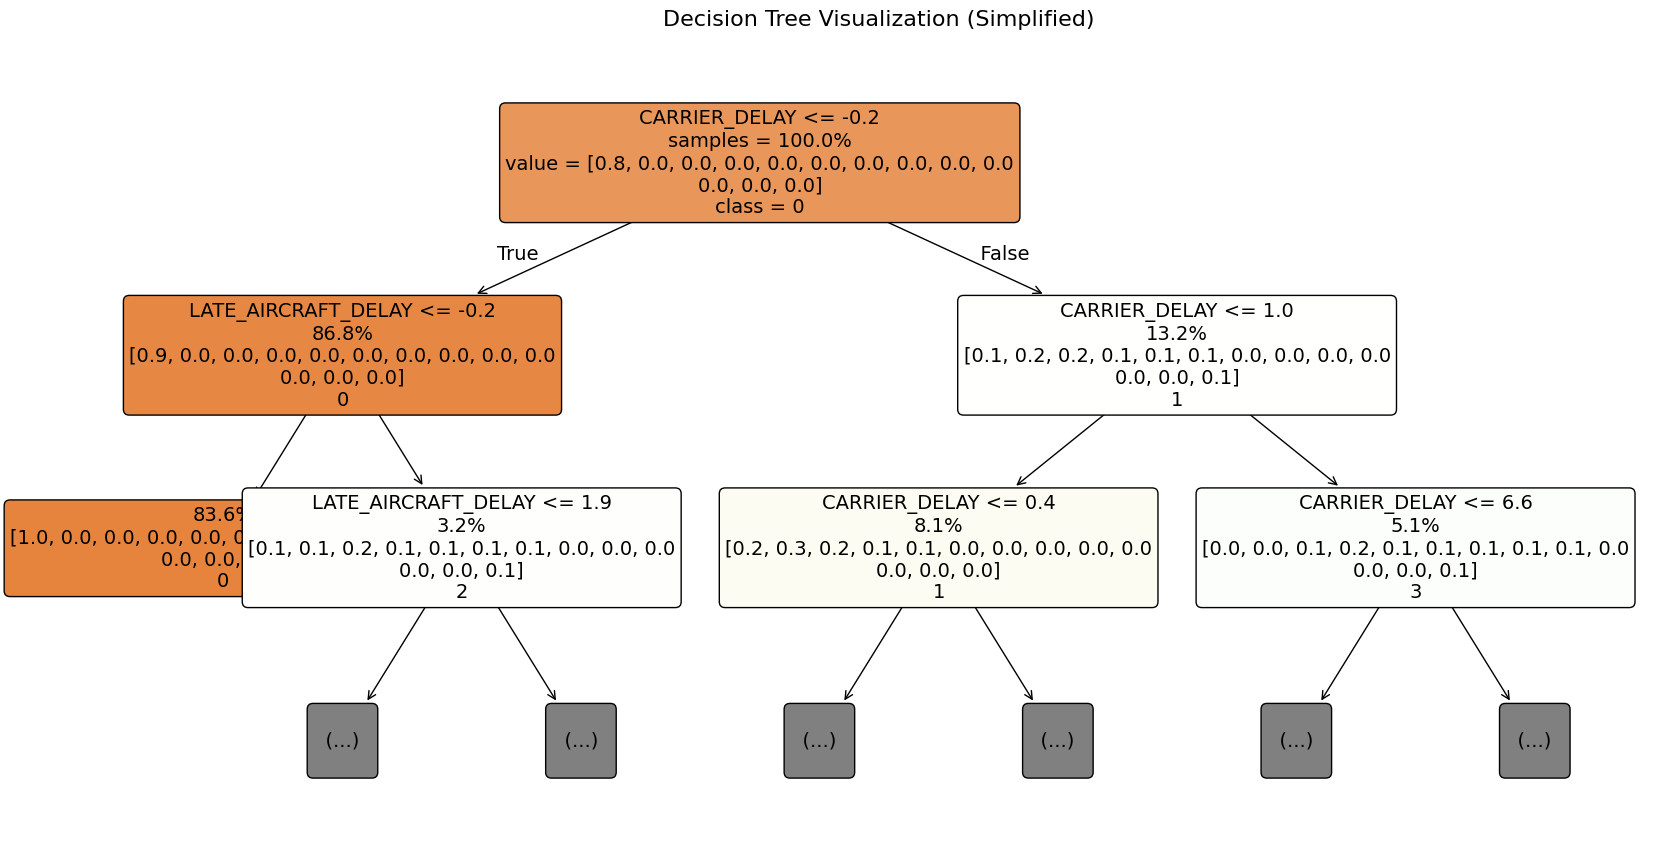

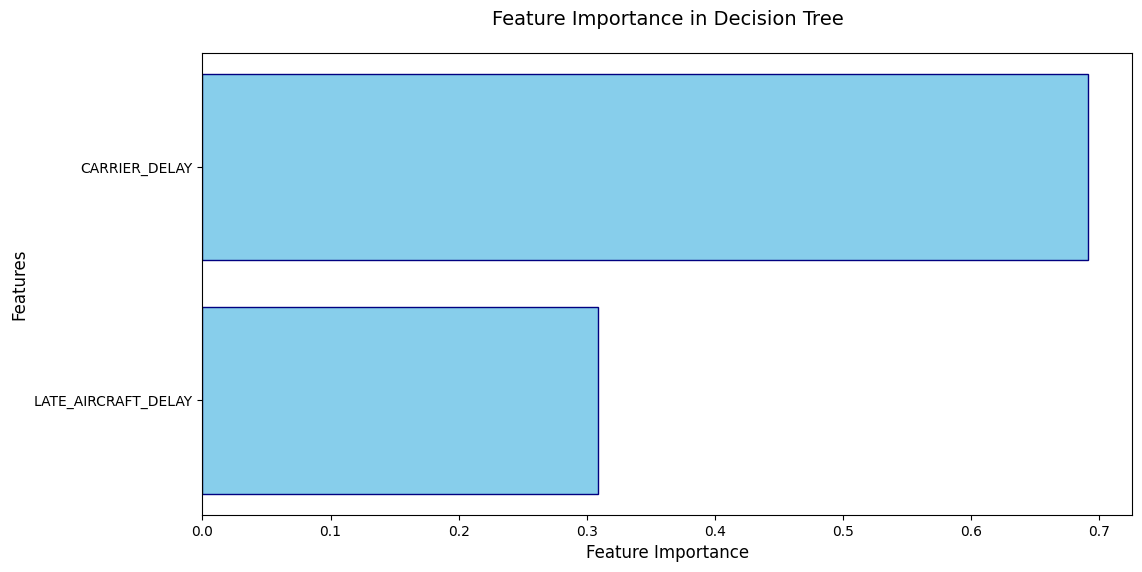

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.8874
Precision: 0.8640
Recall: 0.8874
F1: 0.8745

Test Set Metrics:
Accuracy: 0.8751
Precision: 0.8476
Recall: 0.8751
F1: 0.8605


In [10]:
jfk_DT_model, jfk_metrics_DT = train_decision_tree(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk)

### MIA Baseline Models

In [13]:
# import dataset
merged_mia_df = pd.read_csv('data/complete/MIA_final_df.csv')

# preprocessing
X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia, feature_names_mia = preprocess_data(merged_mia_df)

Epoch [10/100], Loss: 2.6679, Accuracy: 0.0963
Epoch [20/100], Loss: 2.5988, Accuracy: 0.1335
Epoch [30/100], Loss: 2.5308, Accuracy: 0.1791
Epoch [40/100], Loss: 2.4640, Accuracy: 0.2308
Epoch [50/100], Loss: 2.3985, Accuracy: 0.2869
Epoch [60/100], Loss: 2.3342, Accuracy: 0.3431
Epoch [70/100], Loss: 2.2713, Accuracy: 0.3984
Epoch [80/100], Loss: 2.2099, Accuracy: 0.4508
Epoch [90/100], Loss: 2.1498, Accuracy: 0.5003
Epoch [100/100], Loss: 2.0913, Accuracy: 0.5467

Training Set Metrics:
Accuracy: 0.5513
Precision: 0.7384
Recall: 0.5513
F1: 0.6292

Test Set Metrics:
Accuracy: 0.5771
Precision: 0.7585
Recall: 0.5771
F1: 0.6533


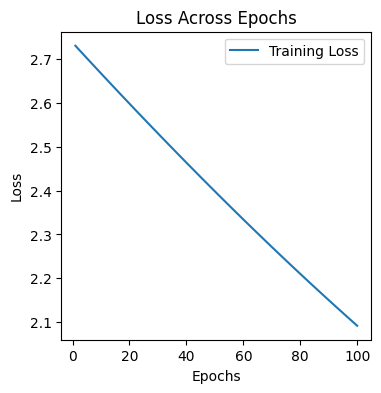

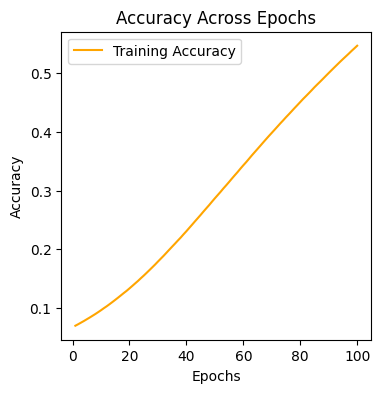

In [14]:
mia_MLR_model, mia_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_mia, Y_train_torch_mia, X_test_torch_mia, Y_test_torch_mia)

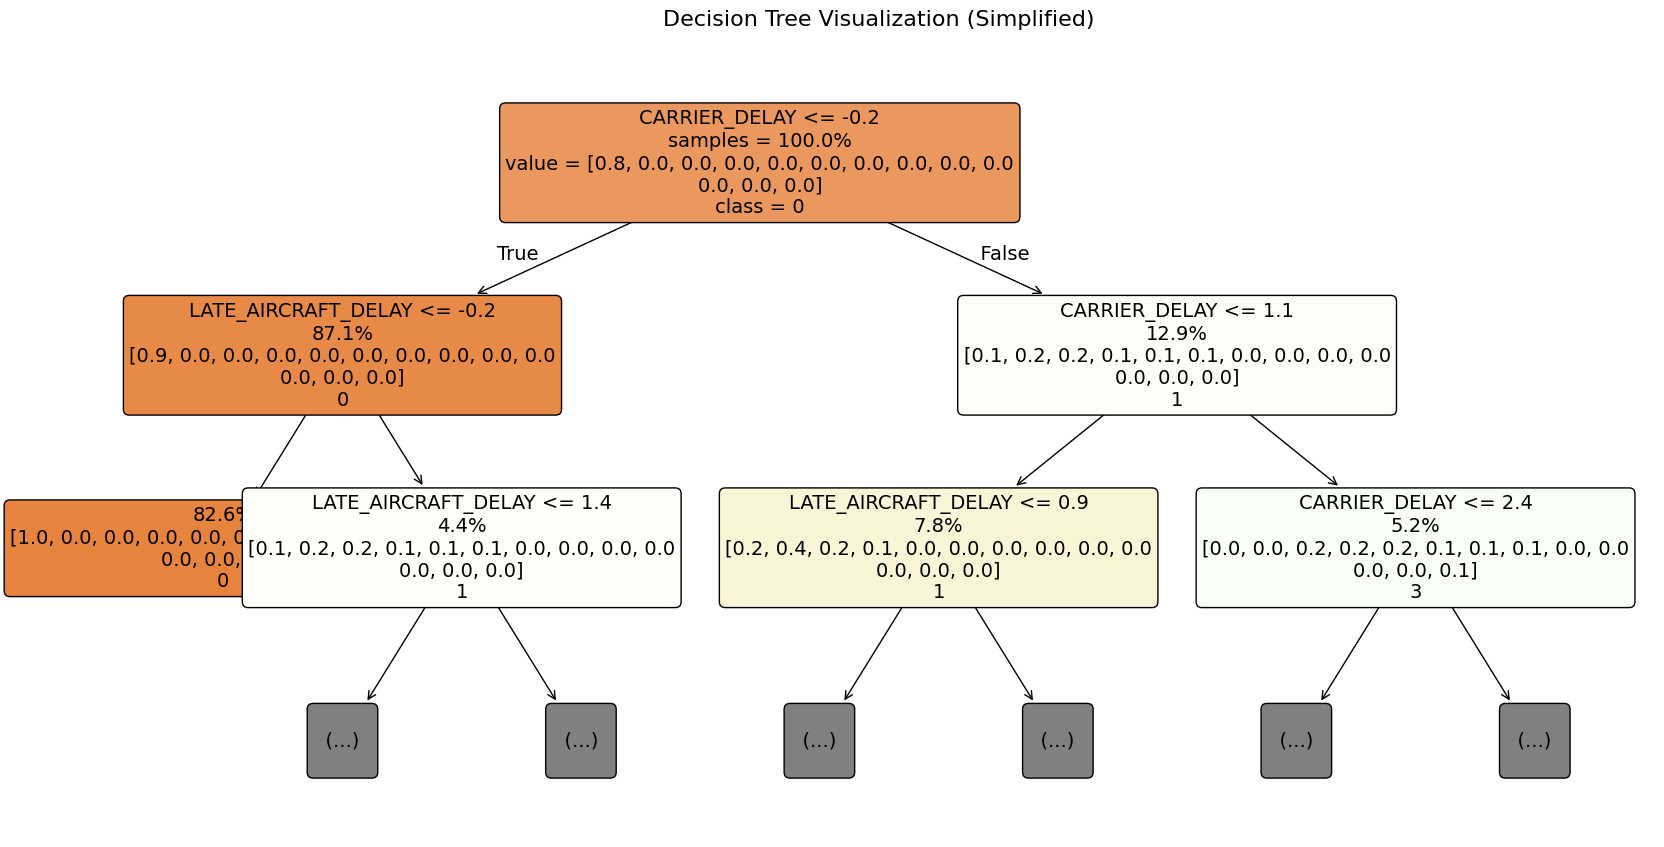

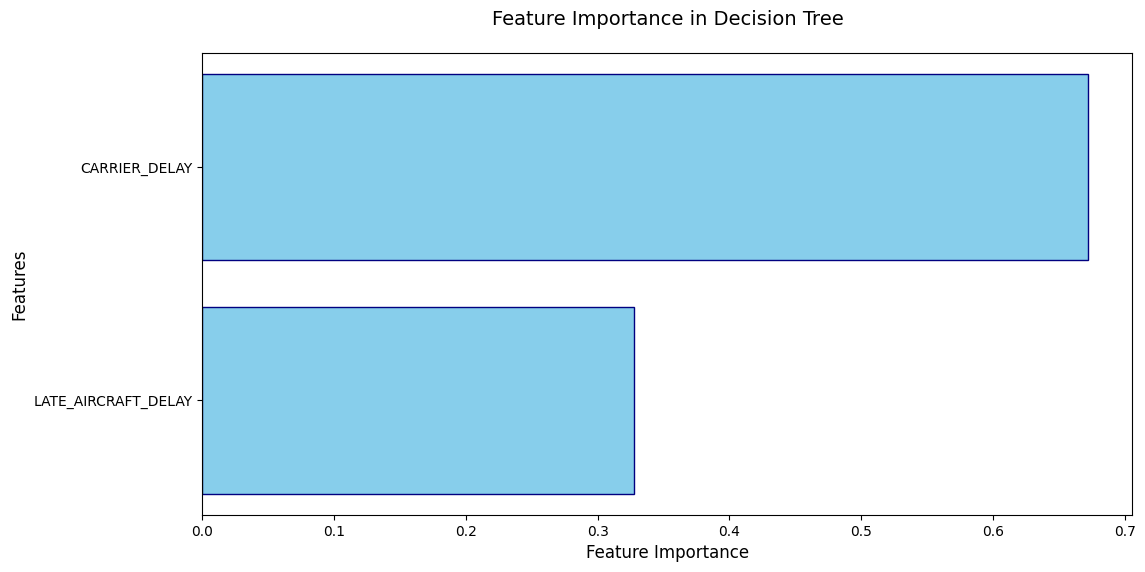


Training Set Metrics:
Accuracy: 0.8878
Precision: 0.8629
Recall: 0.8878
F1: 0.8693

Test Set Metrics:
Accuracy: 0.8821
Precision: 0.8547
Recall: 0.8821
F1: 0.8620


c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
mia_DT_model, mia_metrics_DT = train_decision_tree(X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia, feature_names_mia)

### LAX models

In [6]:
# import dataset
merged_lax_df = pd.read_csv('data/complete/LAX_final_df.csv')

# preprocessing
X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax, feature_names_lax = preprocess_data(merged_lax_df)

Epoch [10/100], Loss: 2.5721, Accuracy: 0.1431
Epoch [20/100], Loss: 2.5021, Accuracy: 0.1892
Epoch [30/100], Loss: 2.4334, Accuracy: 0.2399
Epoch [40/100], Loss: 2.3659, Accuracy: 0.2955
Epoch [50/100], Loss: 2.2999, Accuracy: 0.3571
Epoch [60/100], Loss: 2.2353, Accuracy: 0.4246
Epoch [70/100], Loss: 2.1721, Accuracy: 0.4916
Epoch [80/100], Loss: 2.1104, Accuracy: 0.5522
Epoch [90/100], Loss: 2.0503, Accuracy: 0.6032
Epoch [100/100], Loss: 1.9918, Accuracy: 0.6462

Training Set Metrics:
Accuracy: 0.6501
Precision: 0.7822
Recall: 0.6501
F1: 0.7091

Test Set Metrics:
Accuracy: 0.6351
Precision: 0.7541
Recall: 0.6351
F1: 0.6884


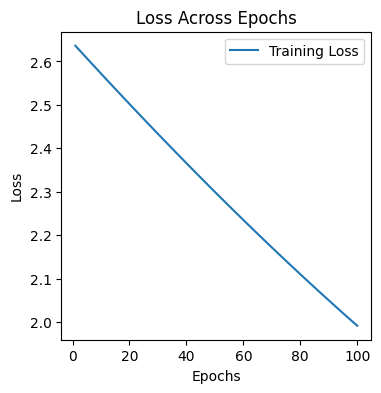

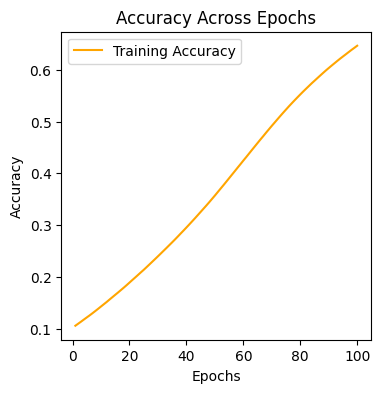

In [7]:
lax_MLR_model, lax_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_lax, Y_train_torch_lax, X_test_torch_lax, Y_test_torch_lax)

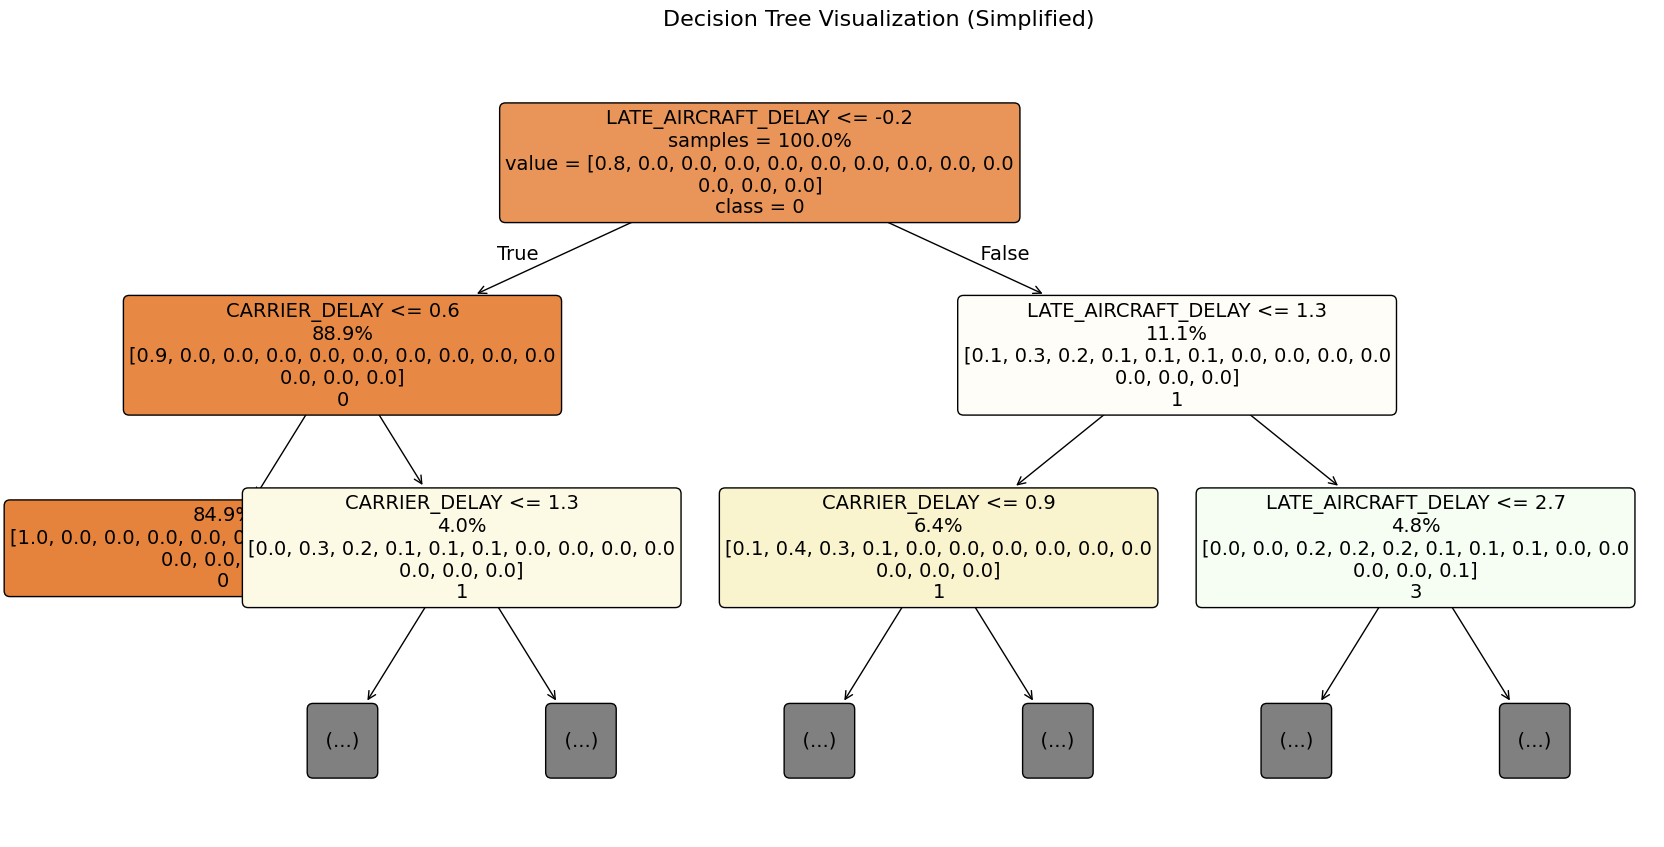

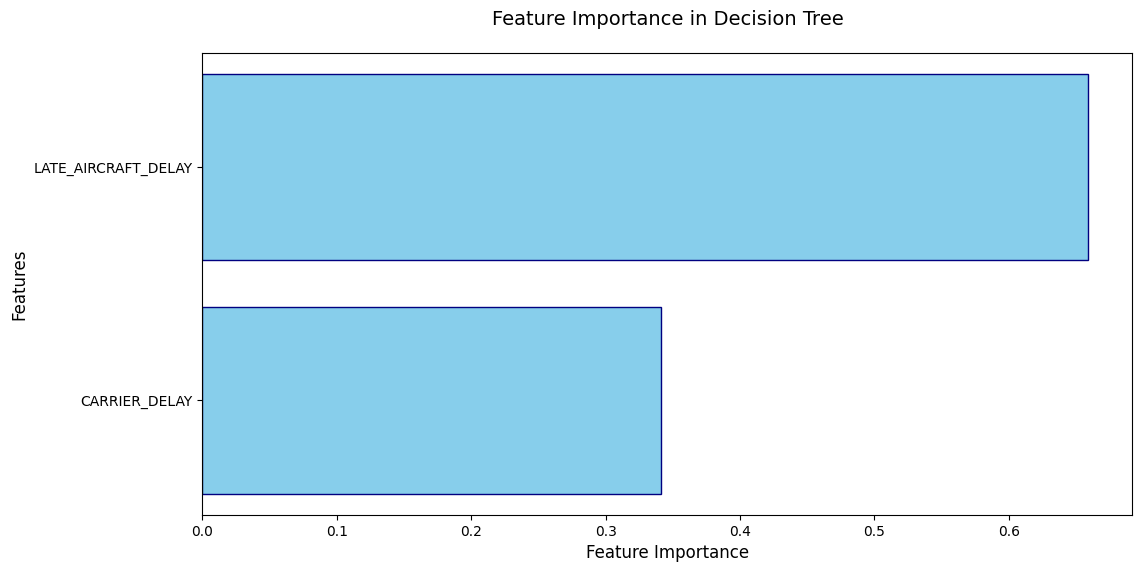

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.9104
Precision: 0.8962
Recall: 0.9104
F1: 0.8999

Test Set Metrics:
Accuracy: 0.8868
Precision: 0.8683
Recall: 0.8868
F1: 0.8732


In [8]:
lax_DT_model, lax_metrics_DT = train_decision_tree(X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax, feature_names_lax)

### EWR Baseline Models

In [13]:
# import dataset
merged_ewr_df = pd.read_csv('data/complete/EWR_final_df.csv')

# preprocessing
X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr, feature_names_ewr = preprocess_data(merged_ewr_df)

Epoch [10/100], Loss: 2.5952, Accuracy: 0.1363
Epoch [20/100], Loss: 2.5277, Accuracy: 0.1786
Epoch [30/100], Loss: 2.4614, Accuracy: 0.2267
Epoch [40/100], Loss: 2.3964, Accuracy: 0.2761
Epoch [50/100], Loss: 2.3329, Accuracy: 0.3264
Epoch [60/100], Loss: 2.2707, Accuracy: 0.3796
Epoch [70/100], Loss: 2.2101, Accuracy: 0.4360
Epoch [80/100], Loss: 2.1509, Accuracy: 0.4938
Epoch [90/100], Loss: 2.0933, Accuracy: 0.5490
Epoch [100/100], Loss: 2.0373, Accuracy: 0.5956

Training Set Metrics:
Accuracy: 0.5997
Precision: 0.7304
Recall: 0.5997
F1: 0.6567

Test Set Metrics:
Accuracy: 0.5832
Precision: 0.7223
Recall: 0.5832
F1: 0.6430


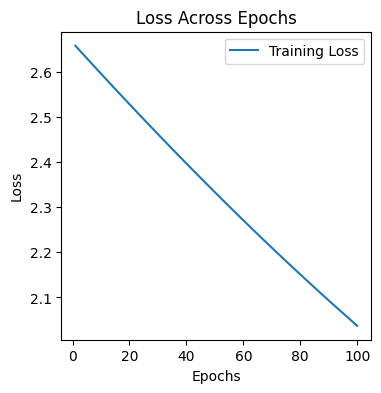

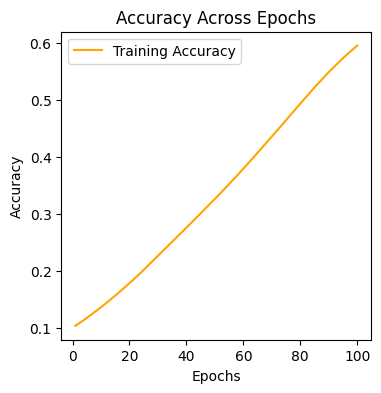

In [15]:
ewr_MLR_model, ewr_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_ewr, Y_train_torch_ewr, X_test_torch_ewr, Y_test_torch_ewr)

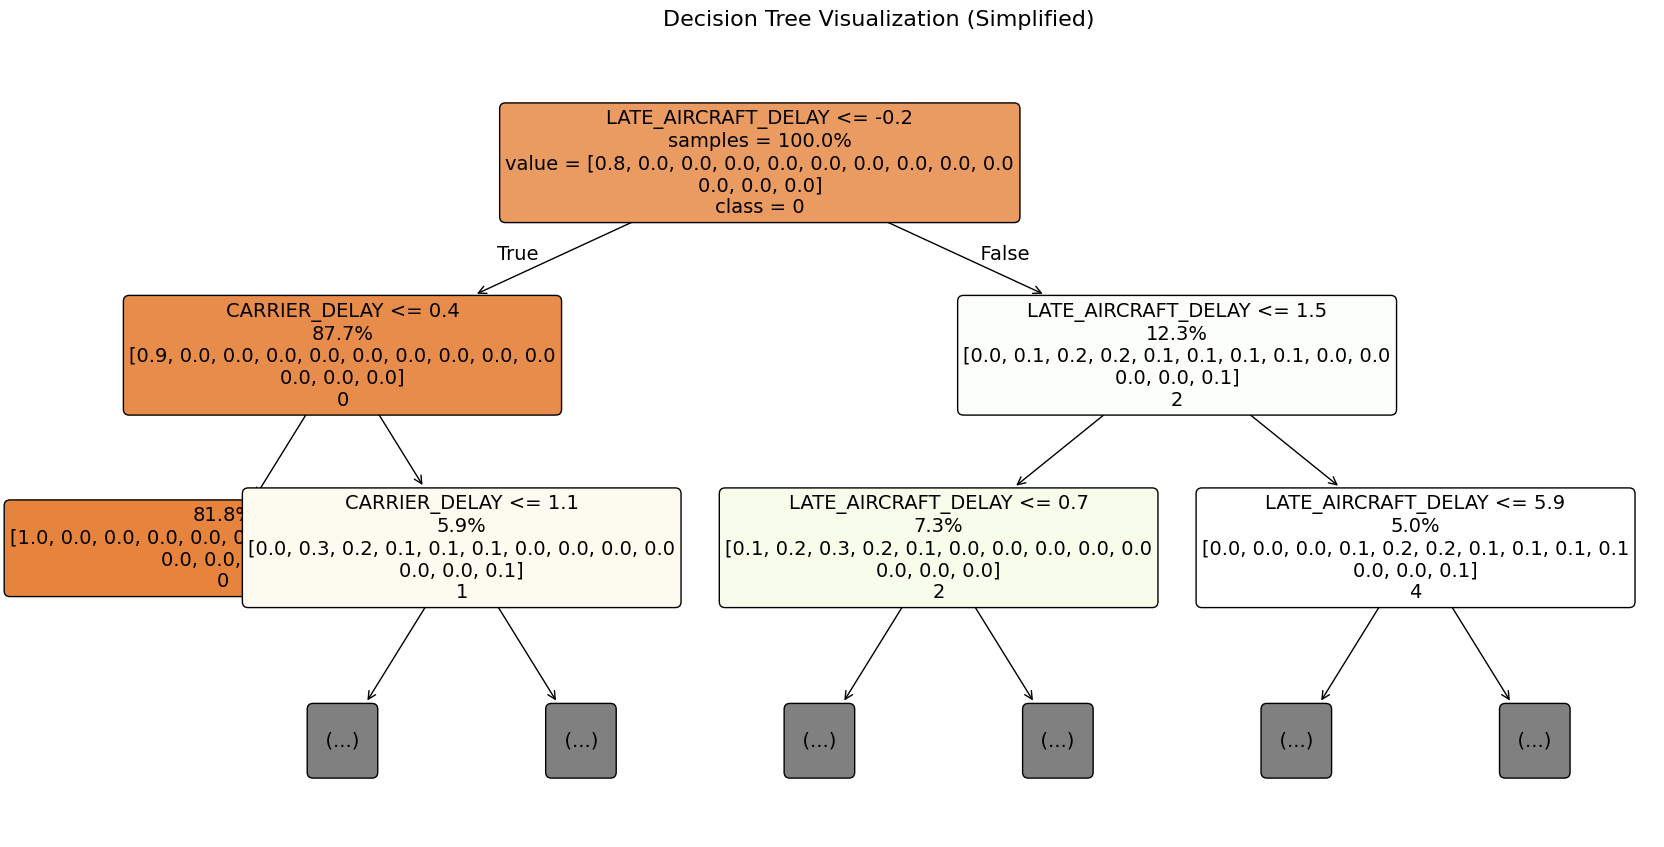

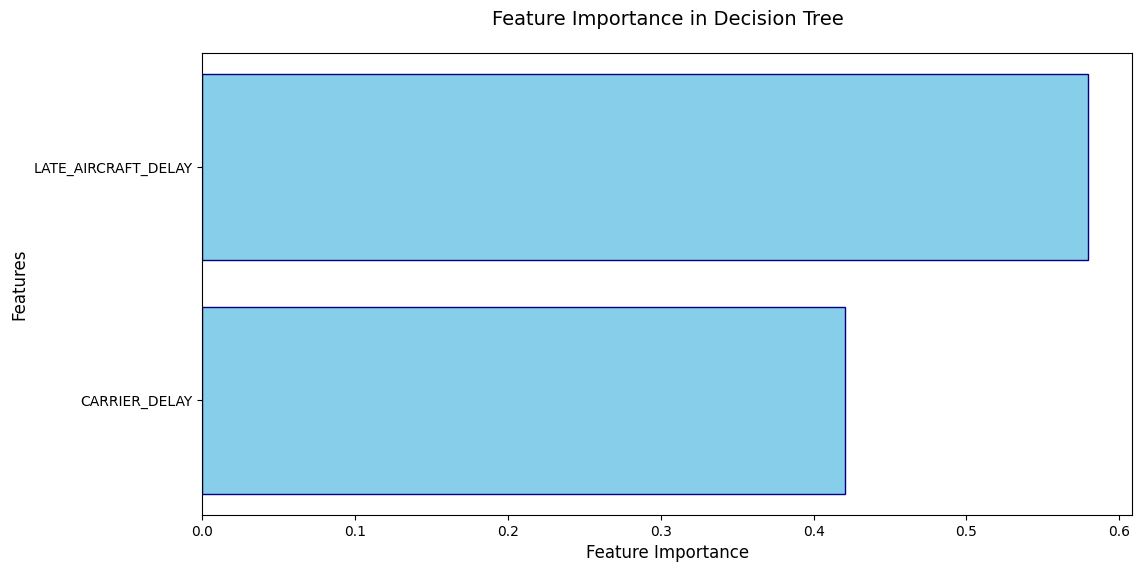

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.8761
Precision: 0.8521
Recall: 0.8761
F1: 0.8597

Test Set Metrics:
Accuracy: 0.8659
Precision: 0.8408
Recall: 0.8659
F1: 0.8481


c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
ewr_DT_model, ewr_metrics_DT = train_decision_tree(X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr, feature_names_ewr)

### ORD Baseline Models

In [3]:
# import dataset
merged_ord_df = pd.read_csv('data/complete/ORD_final_df.csv')

# preprocessing
X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord, feature_names_ord = preprocess_data(merged_ord_df)

Epoch [10/100], Loss: 2.5985, Accuracy: 0.1146
Epoch [20/100], Loss: 2.5334, Accuracy: 0.1649
Epoch [30/100], Loss: 2.4695, Accuracy: 0.2265
Epoch [40/100], Loss: 2.4068, Accuracy: 0.2923
Epoch [50/100], Loss: 2.3455, Accuracy: 0.3536
Epoch [60/100], Loss: 2.2855, Accuracy: 0.4062
Epoch [70/100], Loss: 2.2268, Accuracy: 0.4525
Epoch [80/100], Loss: 2.1696, Accuracy: 0.4950
Epoch [90/100], Loss: 2.1139, Accuracy: 0.5345
Epoch [100/100], Loss: 2.0596, Accuracy: 0.5720

Training Set Metrics:
Accuracy: 0.5756
Precision: 0.6984
Recall: 0.5756
F1: 0.6295

Test Set Metrics:
Accuracy: 0.5916
Precision: 0.7419
Recall: 0.5916
F1: 0.6567


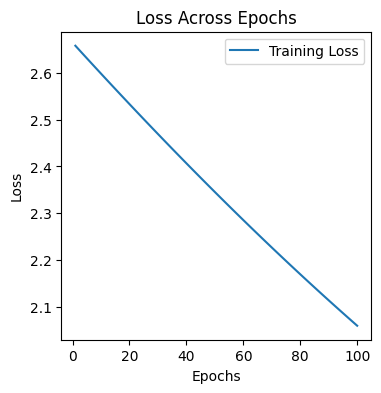

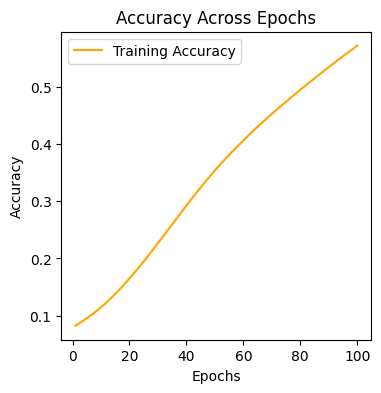

In [6]:
ord_MLR_model, ord_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_ord, Y_train_torch_ord, X_test_torch_ord, Y_test_torch_ord)

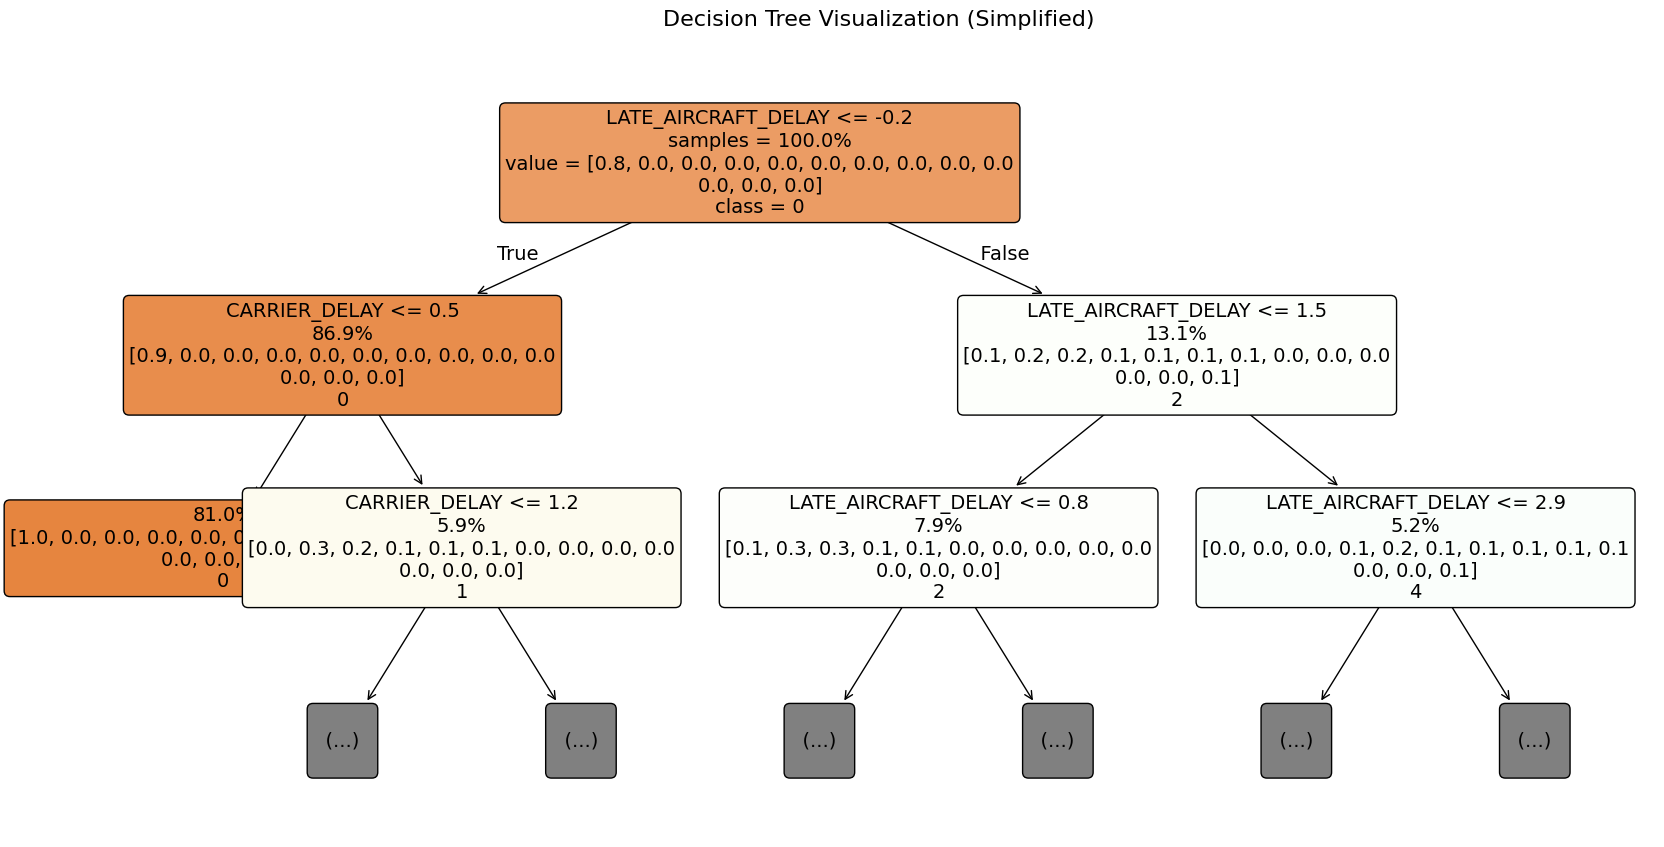

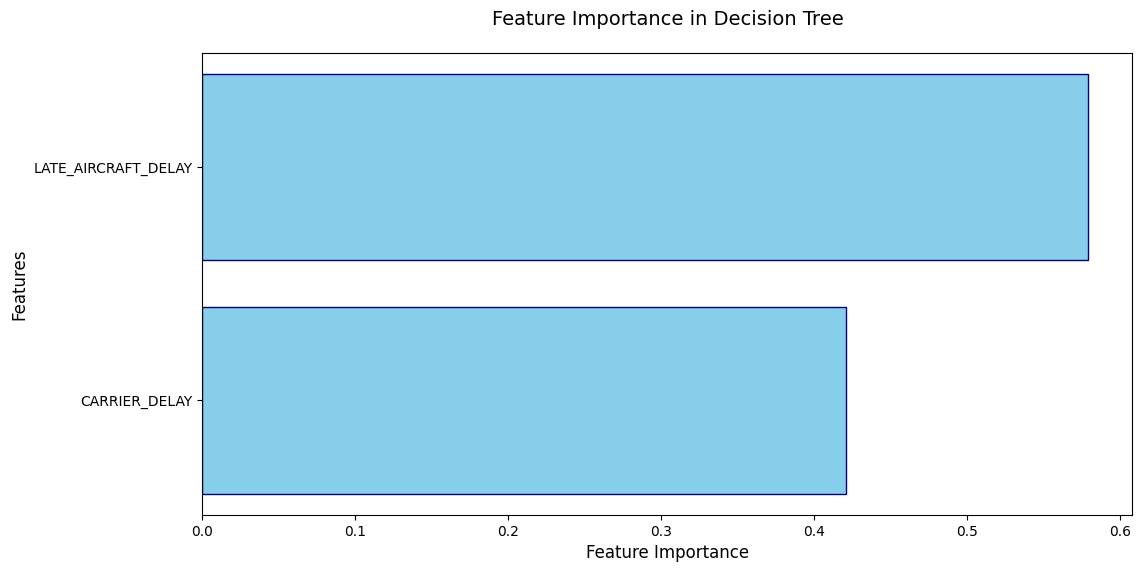

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.8710
Precision: 0.8495
Recall: 0.8710
F1: 0.8558

Test Set Metrics:
Accuracy: 0.8865
Precision: 0.8689
Recall: 0.8865
F1: 0.8736


c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
ord_DT_model, ord_metrics_DT = train_decision_tree(X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord, feature_names_ord)

### SHAP analysis

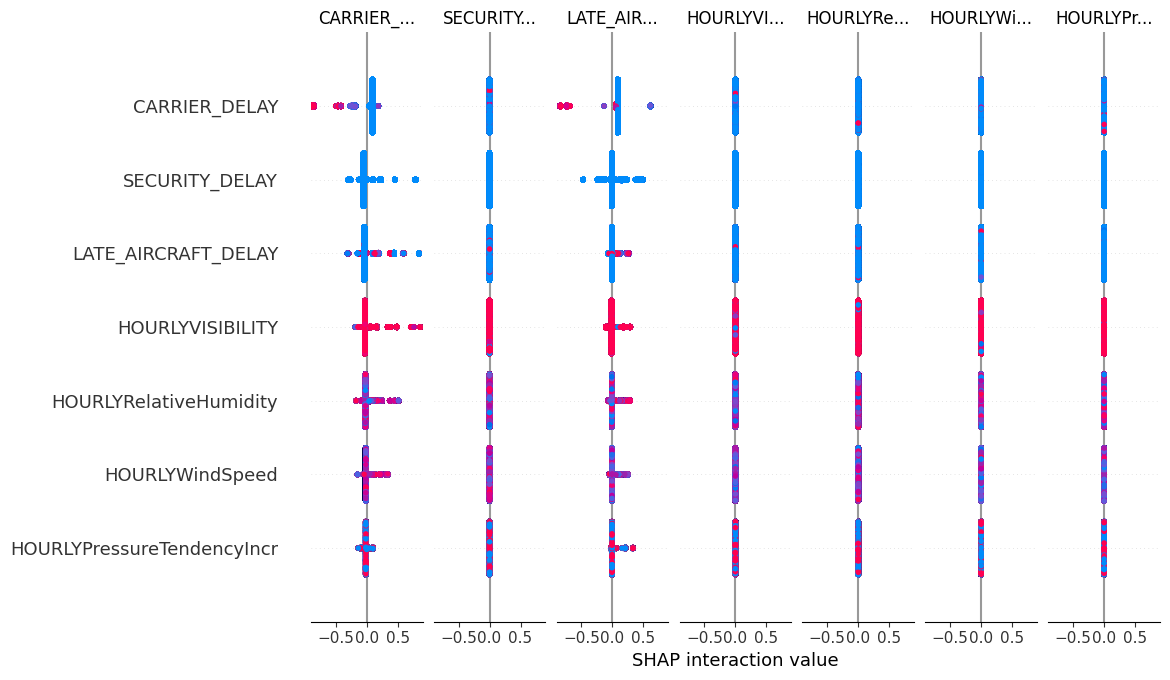

In [11]:
#SHAP DT model

shap.initjs() # Initialize the SHAP JavaScript library

# Convert PyTorch tensor to DataFrame, with column names
X_test_df = pd.DataFrame(X_test_torch_jfk.numpy(), columns=feature_names_jfk)

# Use TreeExplainer with the actual DecisionTreeClassifier inside your wrapper
explainer = shap.TreeExplainer(jfk_DT_model.model)
shap_values = explainer.shap_values(X_test_df)

# Mean SHAP plot
shap.summary_plot(shap_values, X_test_df)

# look at what the table looks like, compare with documentation (run it myself to see what their data looks like)

In [11]:
#SHAP MLR model w/ KernelExplainer 

# Convert PyTorch tensor to DataFrame, with column names
X_test_df = pd.DataFrame(X_test_torch_jfk.numpy(), columns=feature_names_jfk)

# Create the SHAP explainer
explainer = shap.KernelExplainer(jfk_MLR_model, X_test_torch_jfk) # neither passing numpy df or tensors seems to work
shap_values = explainer.shap_values(X_test_df)

# Mean SHAP plot
shap.summary_plot(shap_values, X_test_df)

TypeError: Unknown type passed as data object: <class 'torch.Tensor'>

In [12]:
#SHAP MLR model w/ DeepExplainer 

# Convert PyTorch tensor to DataFrame, with column names
X_test_df = pd.DataFrame(X_test_torch_jfk.numpy(), columns=feature_names_jfk)

# Create the SHAP explainer
explainer = shap.DeepExplainer(jfk_MLR_model, X_test_torch_jfk) 
shap_values = explainer.shap_values(X_test_torch_jfk) # This bit runs infinitely?

# Mean SHAP plot
# shap.summary_plot(shap_values, X_test_torch_jfk)

KeyboardInterrupt: 

In [11]:
#SHAP MLR model w/ LinearExplainer 

explainer = shap.LinearExplainer(jfk_MLR_model, X_test_df)
shap_values = explainer.shap_values(X_test_df)

# Mean SHAP plot
# shap.summary_plot(shap_values, X_test_torch_jfk)

InvalidModelError: An unknown model type was passed: <class '__main__.train_multinomial_logistic_regression.<locals>.MultinomialLogisticRegression'>

to do:
- run baseline models on other datasets
- finalise tables and graphs for baseline models